### Importing Latency Data

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline  
import datetime
import pytz
from datetime import datetime as date

In [13]:
df = pd.read_csv('./workloada_output', header=None, names=['operation', 'timestamp', 'latency'])

In [14]:
df = df.astype(str)

In [15]:
df = df[df.timestamp.apply(lambda x: x.isnumeric())]

In [16]:
df = df[df.latency.apply(lambda x: x.isnumeric())]

In [17]:
df = df.sort_values('timestamp')

In [18]:
df = df.astype({'timestamp': 'float64', 'latency': 'int64'})

In [67]:
initial_records = 1000000 + 1
operations = 15000000
threads = 16
date_today = '2020-12-04'

In [20]:
start_time = df.iloc[initial_records]['timestamp']

In [21]:
end_time = df.iloc[-1]['timestamp']

### Importing Compactions Data

In [22]:
compactions = pd.read_csv("./compactions.txt", sep=";", header=None,names=['task', 'start', 'end'])

In [23]:
def comp_to_utc(dateTime):
    local = pytz.timezone ('Asia/Kolkata')
    naive_datetime = datetime.datetime.strptime (dateTime, "%Y-%m-%d %H:%M:%S,%f")
    local_datetime = local.localize(naive_datetime, is_dst=None)
    utc_dt = local_datetime.astimezone(pytz.utc)
    return utc_dt.timestamp()*1000

In [24]:
compactions_start = []
compactions_end = []

for index, row in compactions.iterrows():
    compactions_start.append(comp_to_utc(row['start']))
    compactions_end.append(comp_to_utc(row['end']))

In [25]:
compactions['start_utc'] = compactions['start'].apply(comp_to_utc)
compactions['end_utc'] = compactions['end'].apply(comp_to_utc)

In [26]:
compactions = compactions.loc[compactions['start_utc'] >= start_time]

In [27]:
compactions

,task,start,end,start_utc,end_utc
18,8268,"2020-12-04 15:51:04,667","2020-12-04 15:51:43,786",1.607077e+12,1.607077e+12
19,8266,"2020-12-04 15:52:44,787","2020-12-04 15:53:24,238",1.607077e+12,1.607077e+12
20,8270,"2020-12-04 15:54:27,899","2020-12-04 15:55:06,433",1.607077e+12,1.607078e+12


### Plotting the latency graph

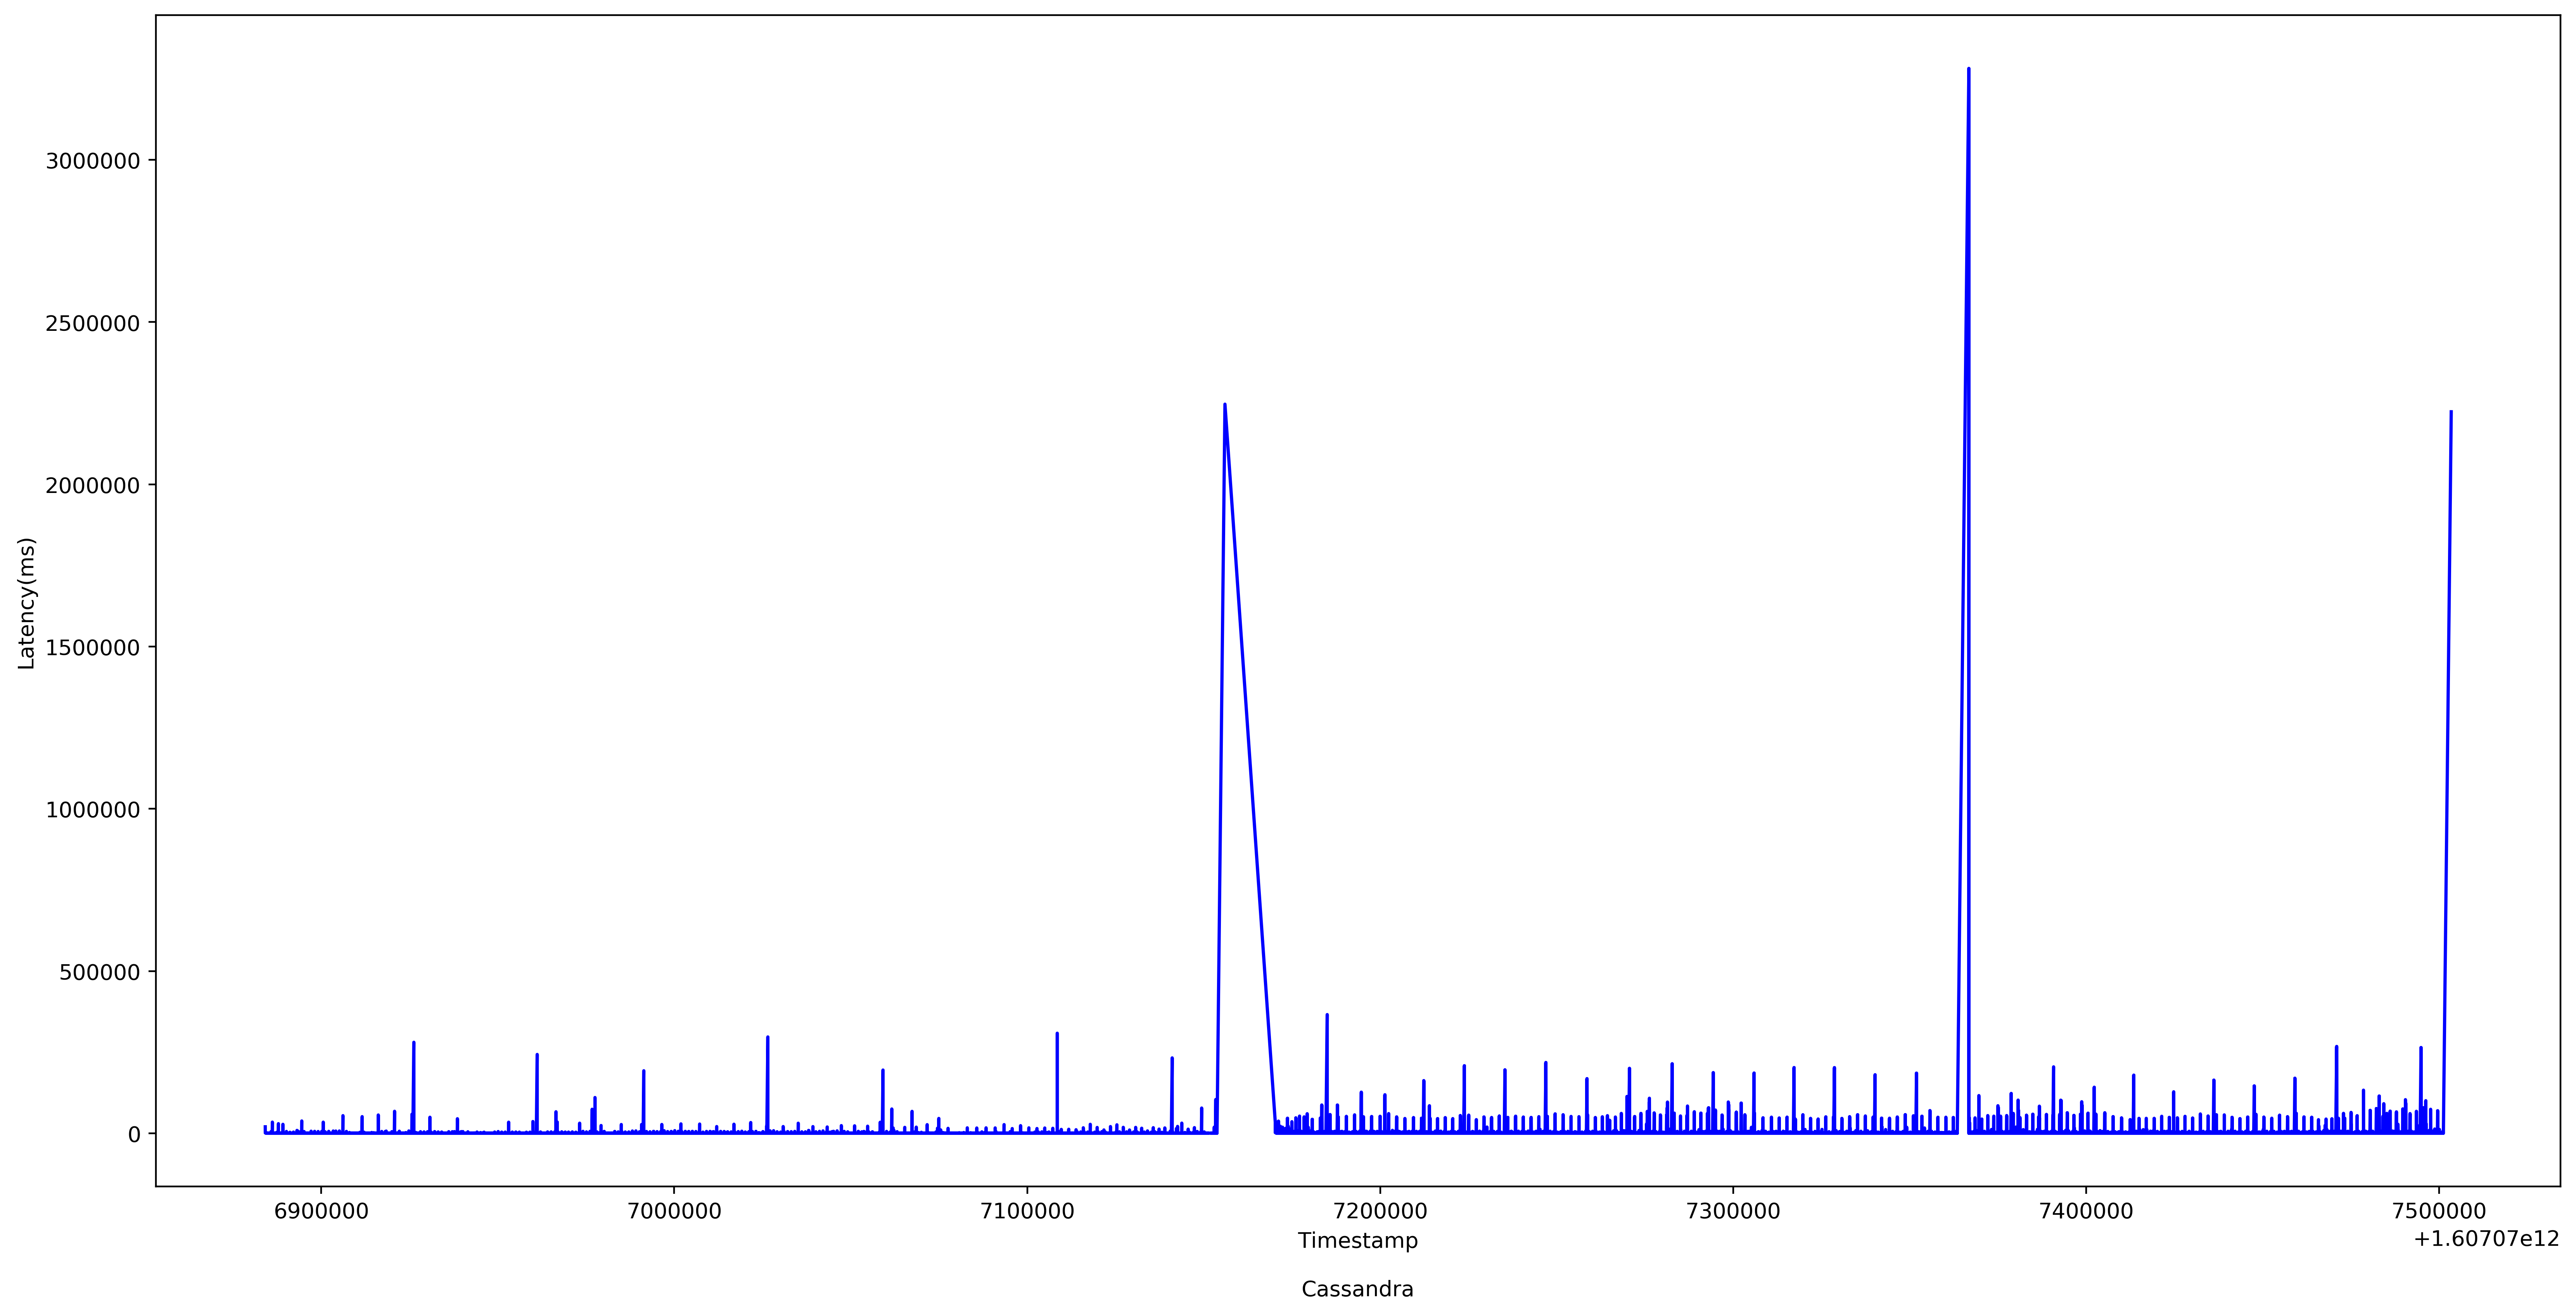

In [28]:
plt.figure(figsize=(20,10), dpi=400)
plt.plot(df.timestamp, df.latency, color='b')

plt.xlabel("Timestamp\n\nCassandra")
plt.ylabel("Latency(ms)")
plt.show()

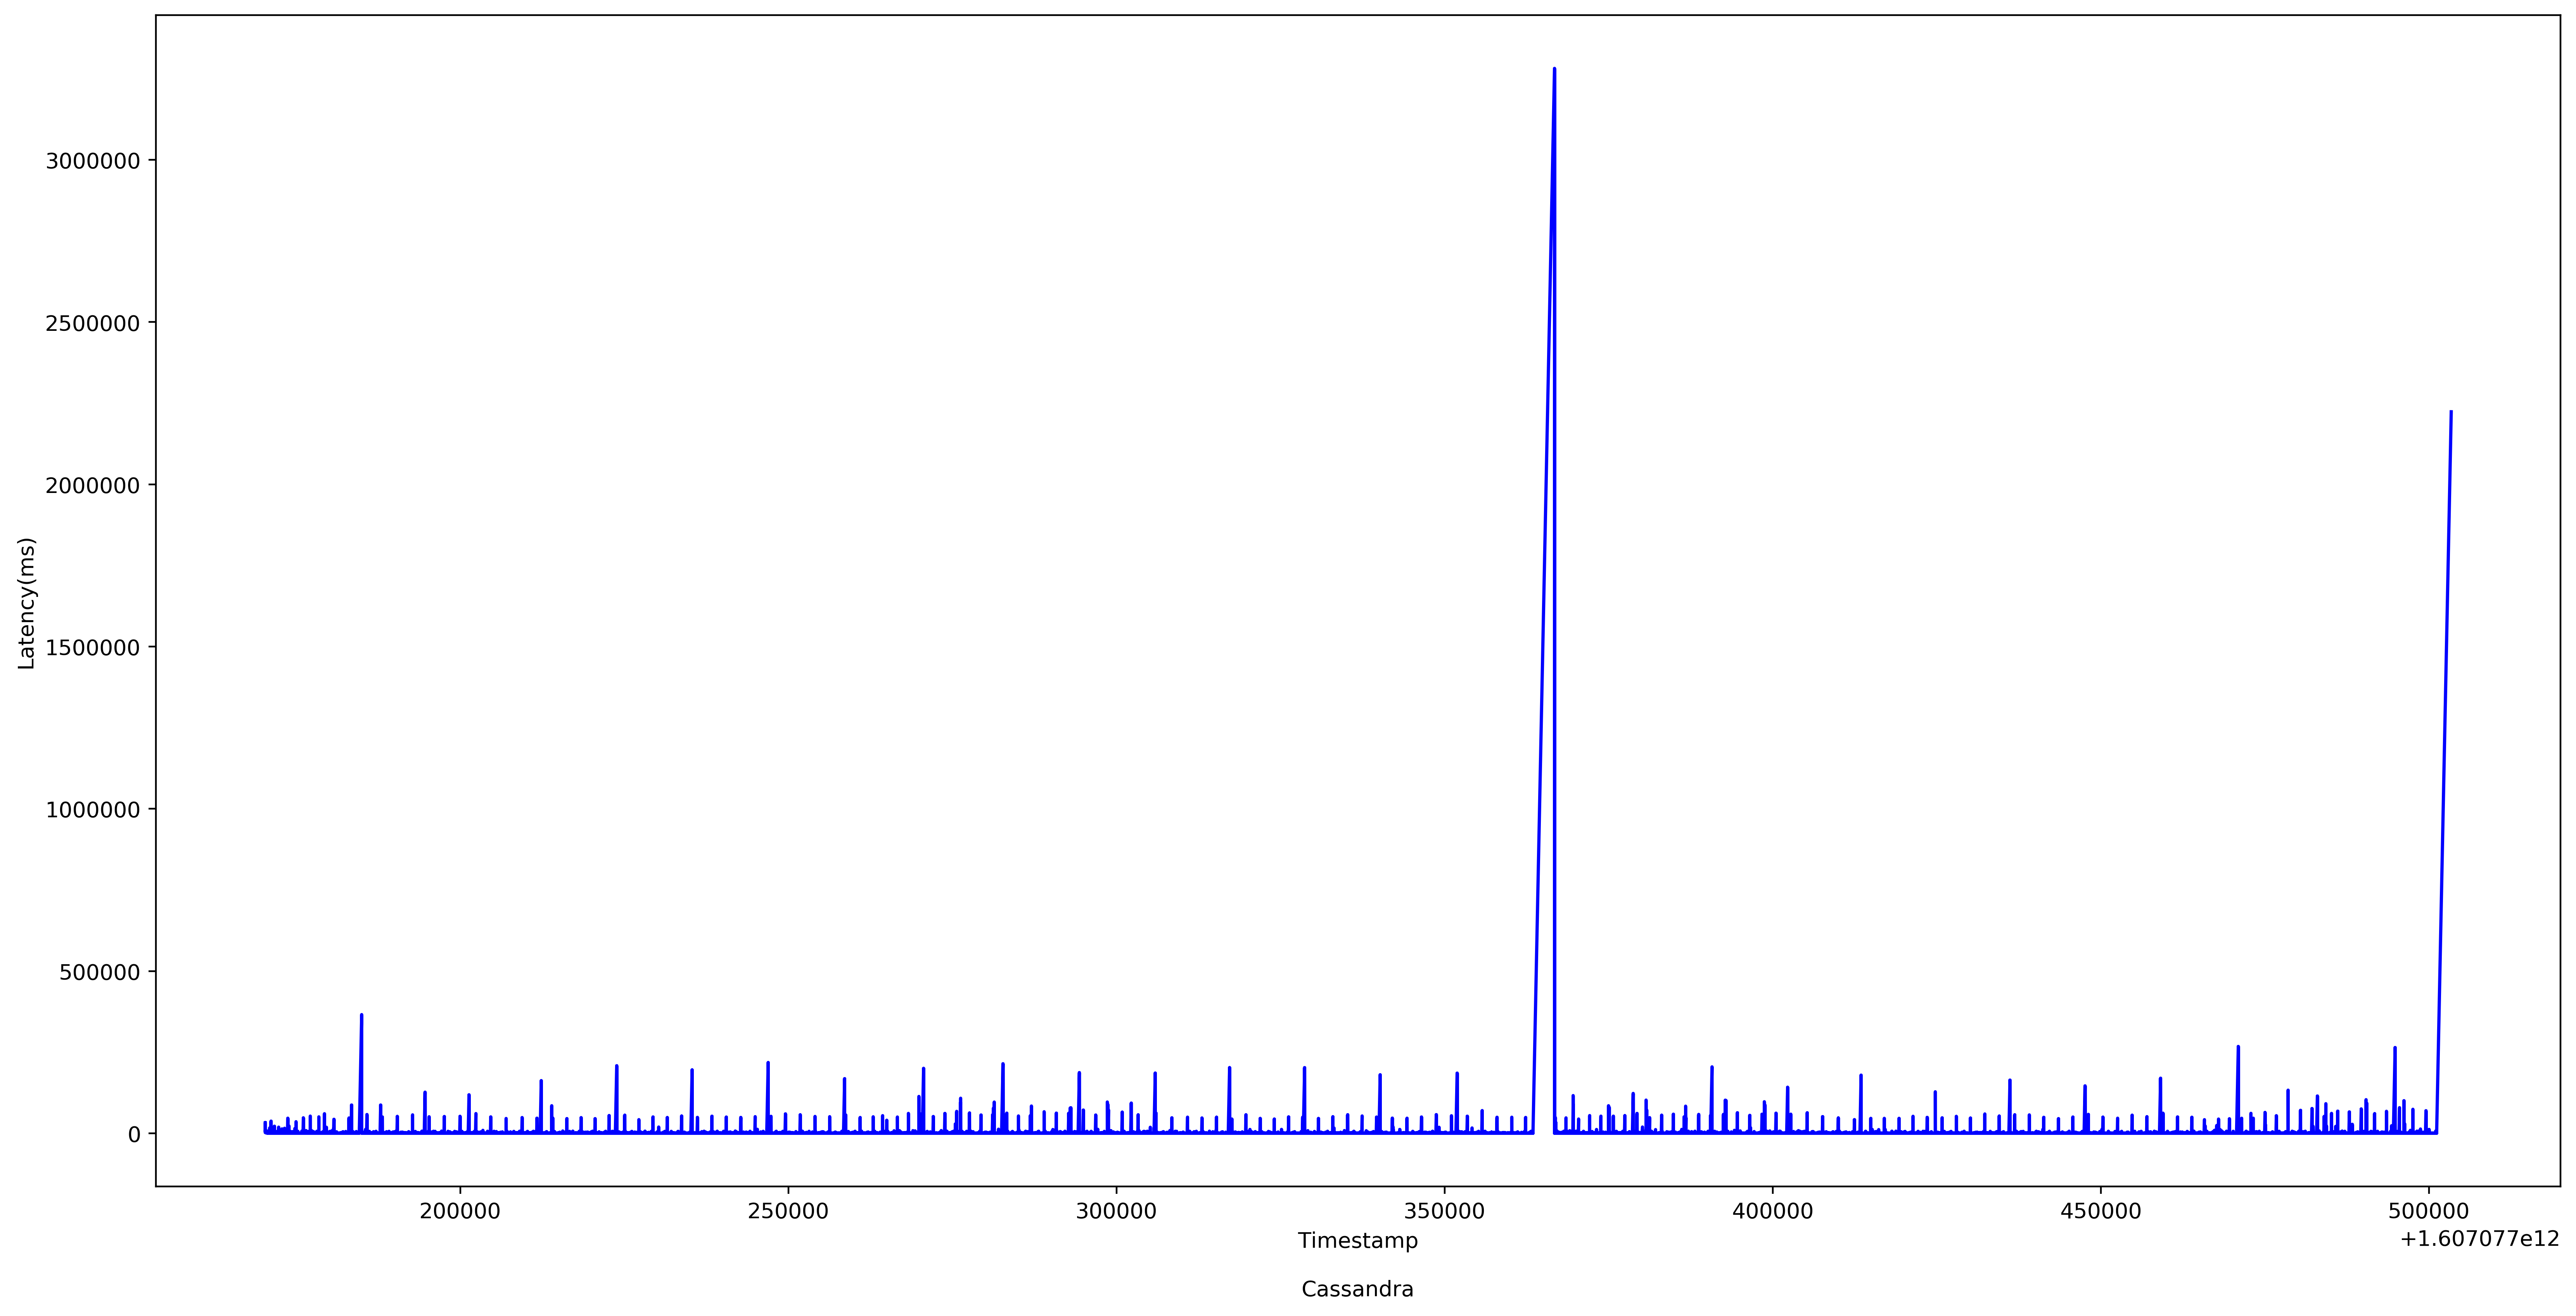

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figsize=(20,10), dpi=400)
plt.plot(df.timestamp[initial_records:], df.latency[initial_records:], color='b')

plt.xlabel("Timestamp\n\nCassandra")
plt.ylabel("Latency(ms)")
plt.show()
plt.savefig('Cassandra Workload A')

### Plotting Latencies and Compactions

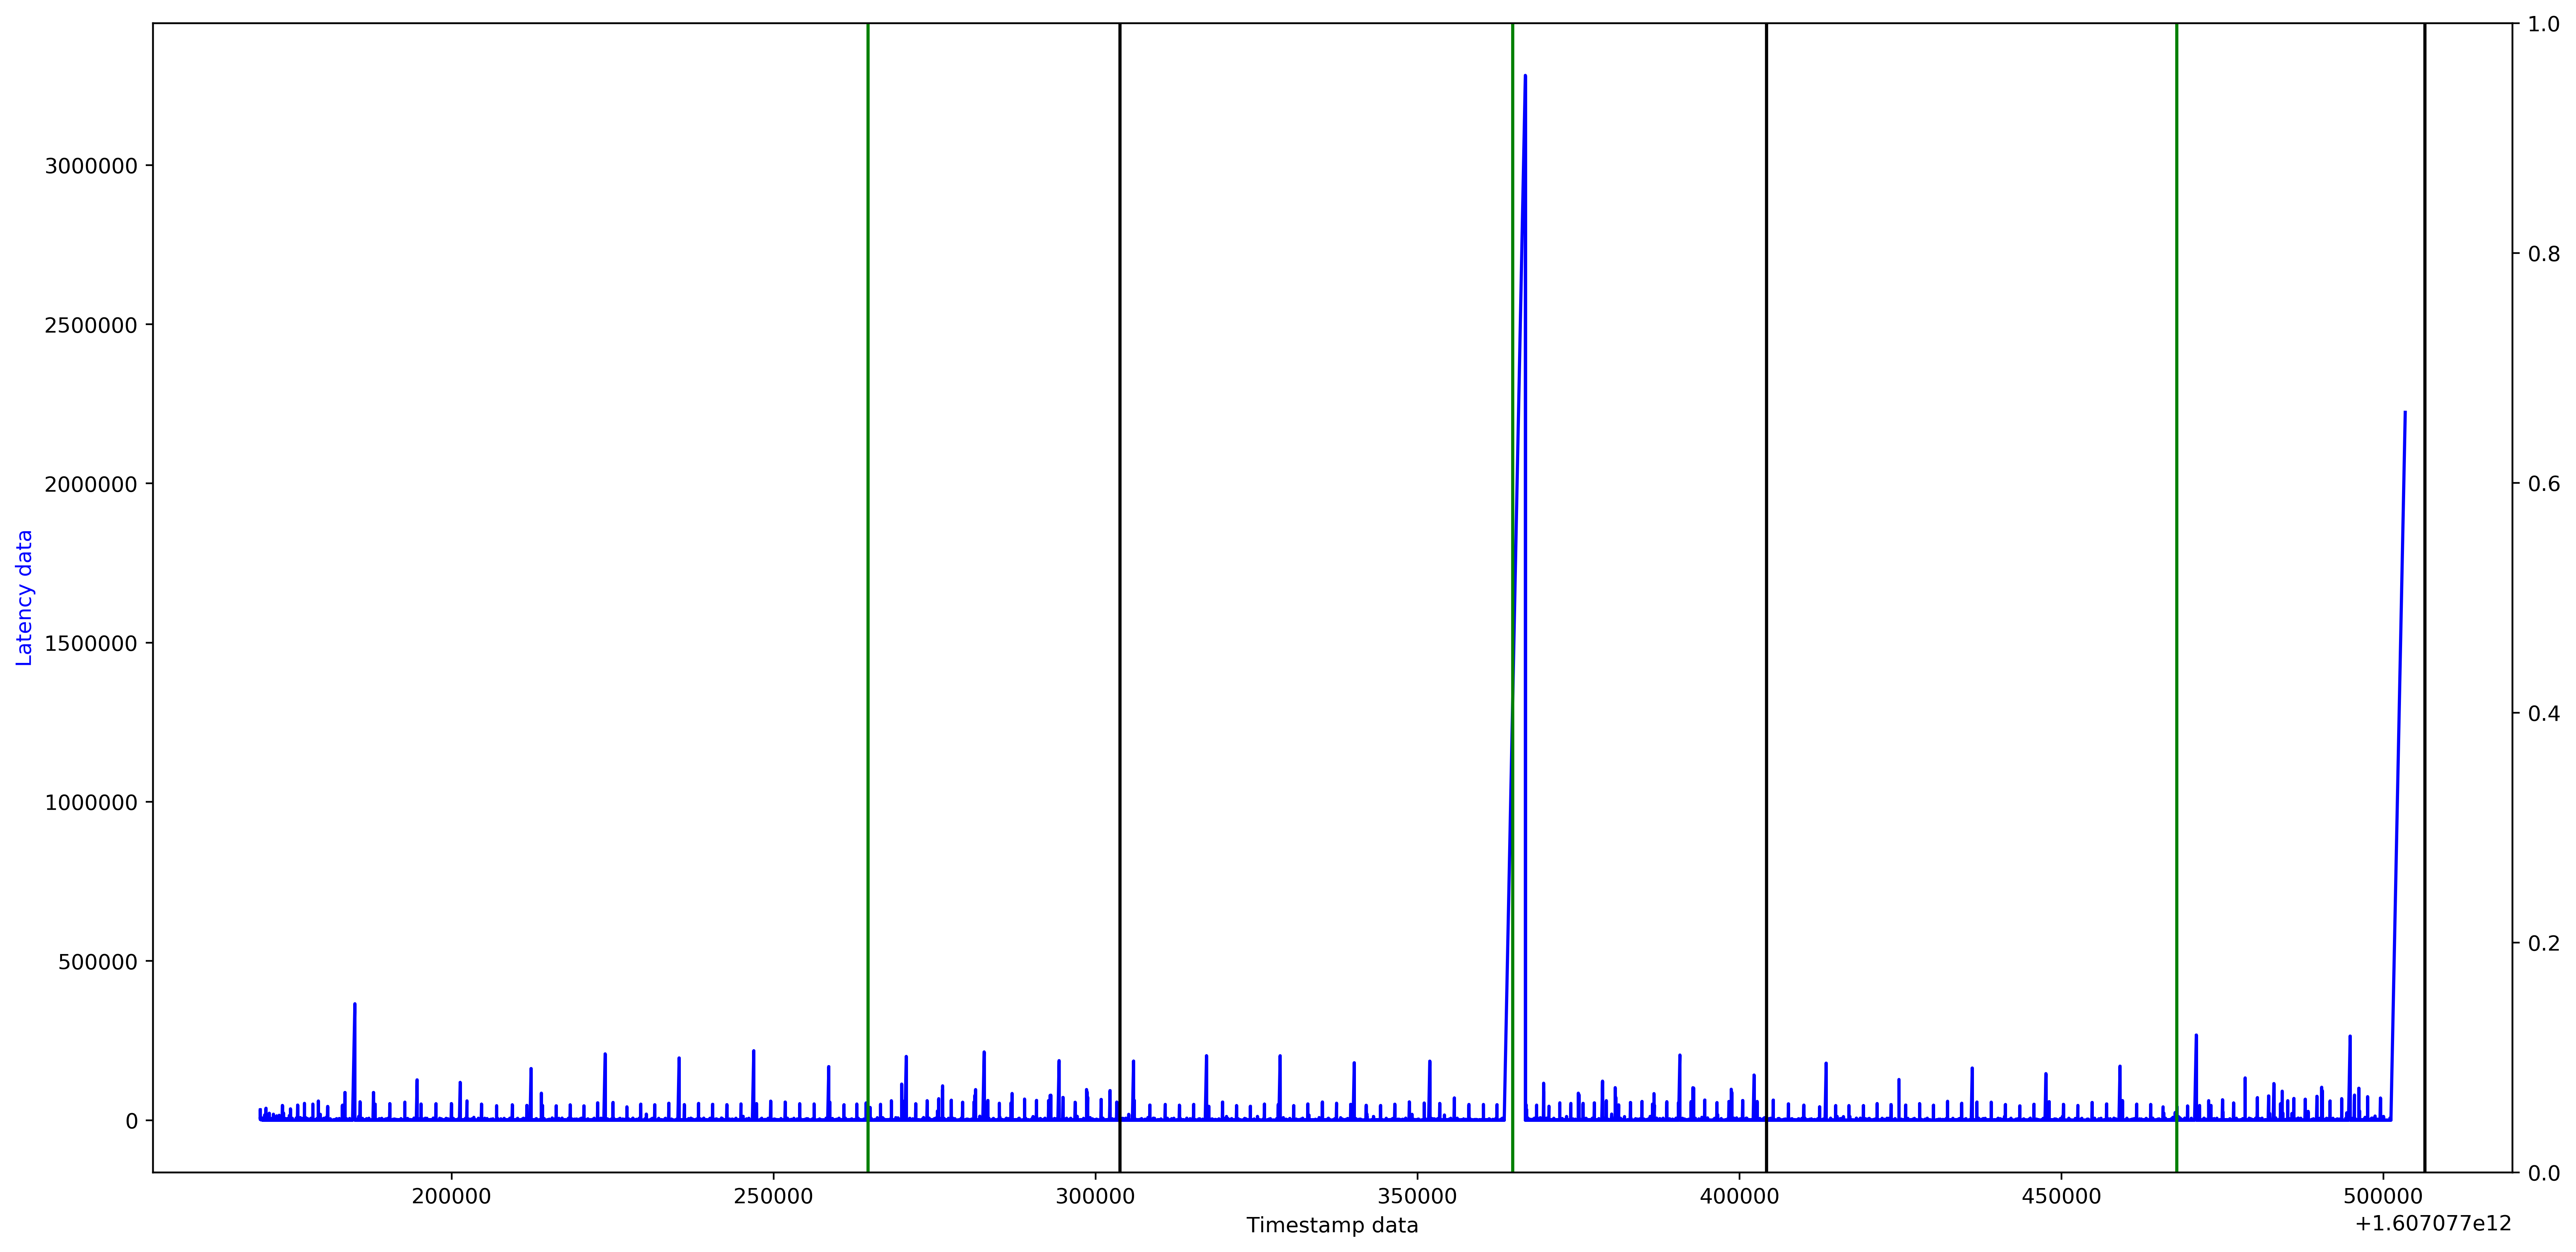

<Figure size 432x288 with 0 Axes>

In [30]:
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=400)

ax2 = ax1.twinx()
ax1.plot(df.timestamp[initial_records:], df.latency[initial_records:], color='b')

for index, row in compactions.iterrows():
    ax2.axvline(x=row['start_utc'], color='g')
    ax2.axvline(x=row['end_utc'], color='k')

ax1.set_xlabel('Timestamp data')
ax1.set_ylabel('Latency data', color='b')

plt.xlabel("Timestamp\n\nCassandra")
plt.show()
plt.savefig('Cassandra Workload A')

### Plotting Latencies and GC stops

In [31]:
gc_logs = pd.read_csv("./gc_stops.txt", sep=";")

In [32]:
def gc_to_utc(dateTime):
    dateTime = dateTime[:-6]
    local = pytz.timezone ('Asia/Kolkata')
    naive_datetime = datetime.datetime.strptime (dateTime, "%Y-%m-%dT%H:%M:%S.%f")
    local_datetime = local.localize(naive_datetime, is_dst=None)
    utc_dt = local_datetime.astimezone(pytz.utc)
    return utc_dt.timestamp()*1000

In [33]:
gc_logs['timestamp'] = gc_logs['time'].apply(gc_to_utc)
gc_logs['total_time'] = gc_logs['stopping_duration'] + gc_logs['stopping_time']

In [34]:
gc_logs = gc_logs.loc[gc_logs['timestamp'] >= start_time]

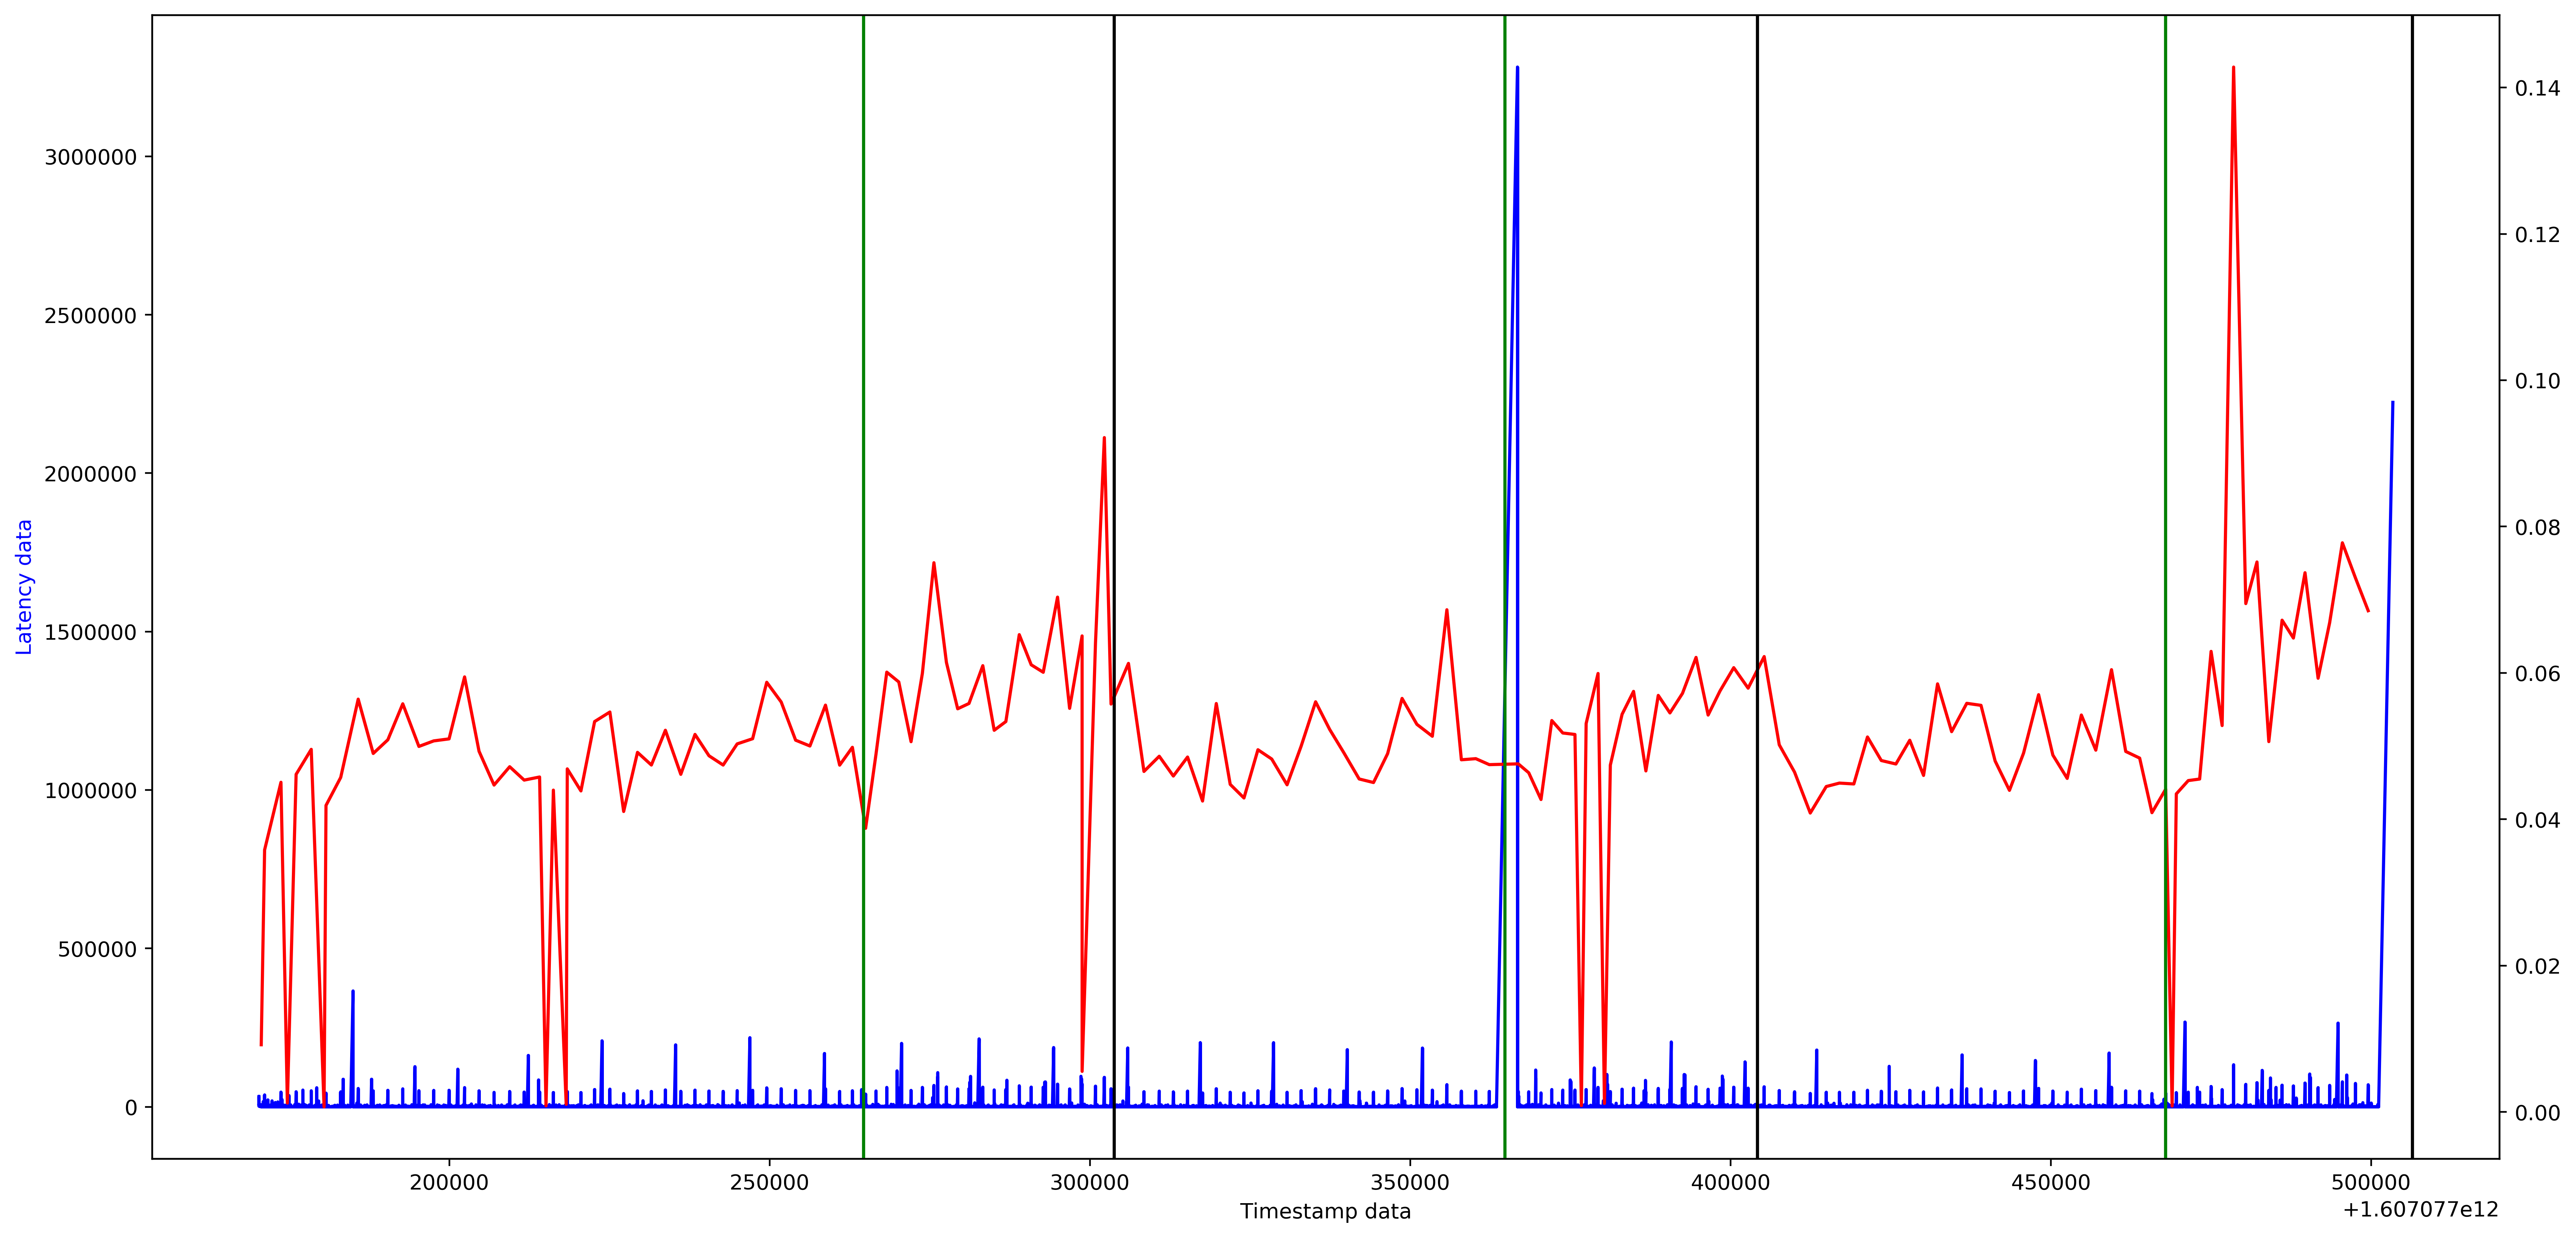

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=400)

ax2 = ax1.twinx()
ax1.plot(df.timestamp[initial_records:], df.latency[initial_records:], color='b')

ax2.plot(gc_logs.timestamp, gc_logs.total_time, color='r')

for index, row in compactions.iterrows():
    ax2.axvline(x=row['start_utc'], color='g')
    ax2.axvline(x=row['end_utc'], color='k')


ax1.set_xlabel('Timestamp data')
ax1.set_ylabel('Latency data', color='b')

plt.xlabel("Timestamp\n\nCassandra")
plt.show()

### Plotting CPU Utilization

In [58]:
cpu_util = pd.read_csv('./cpuutil.csv', skiprows = 1,header = None, names=['time', 'IST', '%user', '%nice', '%system', '%iowait', '%steal',
       '%idle'])

In [59]:
cpu_util

,time,IST,%user,%nice,%system,%iowait,%steal,%idle
0,03:44:37,IST,10.48,0.0,0.97,0.06,0.0,88.49
1,03:44:38,IST,24.59,0.0,0.97,0.00,0.0,74.44
2,03:44:39,IST,24.74,0.0,1.19,0.00,0.0,74.07
3,03:44:40,IST,26.49,0.0,0.56,0.00,0.0,72.95
4,03:44:41,IST,28.50,0.0,1.09,0.00,0.0,70.40
...,...,...,...,...,...,...,...,...
1158,04:03:55,IST,0.03,0.0,0.16,0.00,0.0,99.81
1159,04:03:56,IST,0.06,0.0,0.16,0.00,0.0,99.78
1160,04:03:57,IST,0.06,0.0,0.13,0.03,0.0,99.78
1161,04:03:58,IST,0.09,0.0,0.19,0.00,0.0,99.72


In [68]:
def cpu_to_utc(dt):
    local = pytz.timezone ('Asia/Kolkata')
    if(dt[0:2] == "03"): 
        dt = date_today + " 15:" + dt[3:] 
    else:
        dt = date_today + " 16:" + dt[3:]
        
    naive_datetime = datetime.datetime.strptime (dt, "%Y-%m-%d %H:%M:%S")
    local_datetime = local.localize(naive_datetime, is_dst=None)
    utc_dt = local_datetime.astimezone(pytz.utc)
    return utc_dt.timestamp()*1000

In [69]:
cpu_util['timestamp'] = cpu_util['time'].apply(cpu_to_utc)

In [73]:
cpu_util = cpu_util.loc[(cpu_util['timestamp'] >= start_time) & (cpu_util['timestamp'] < end_time)]

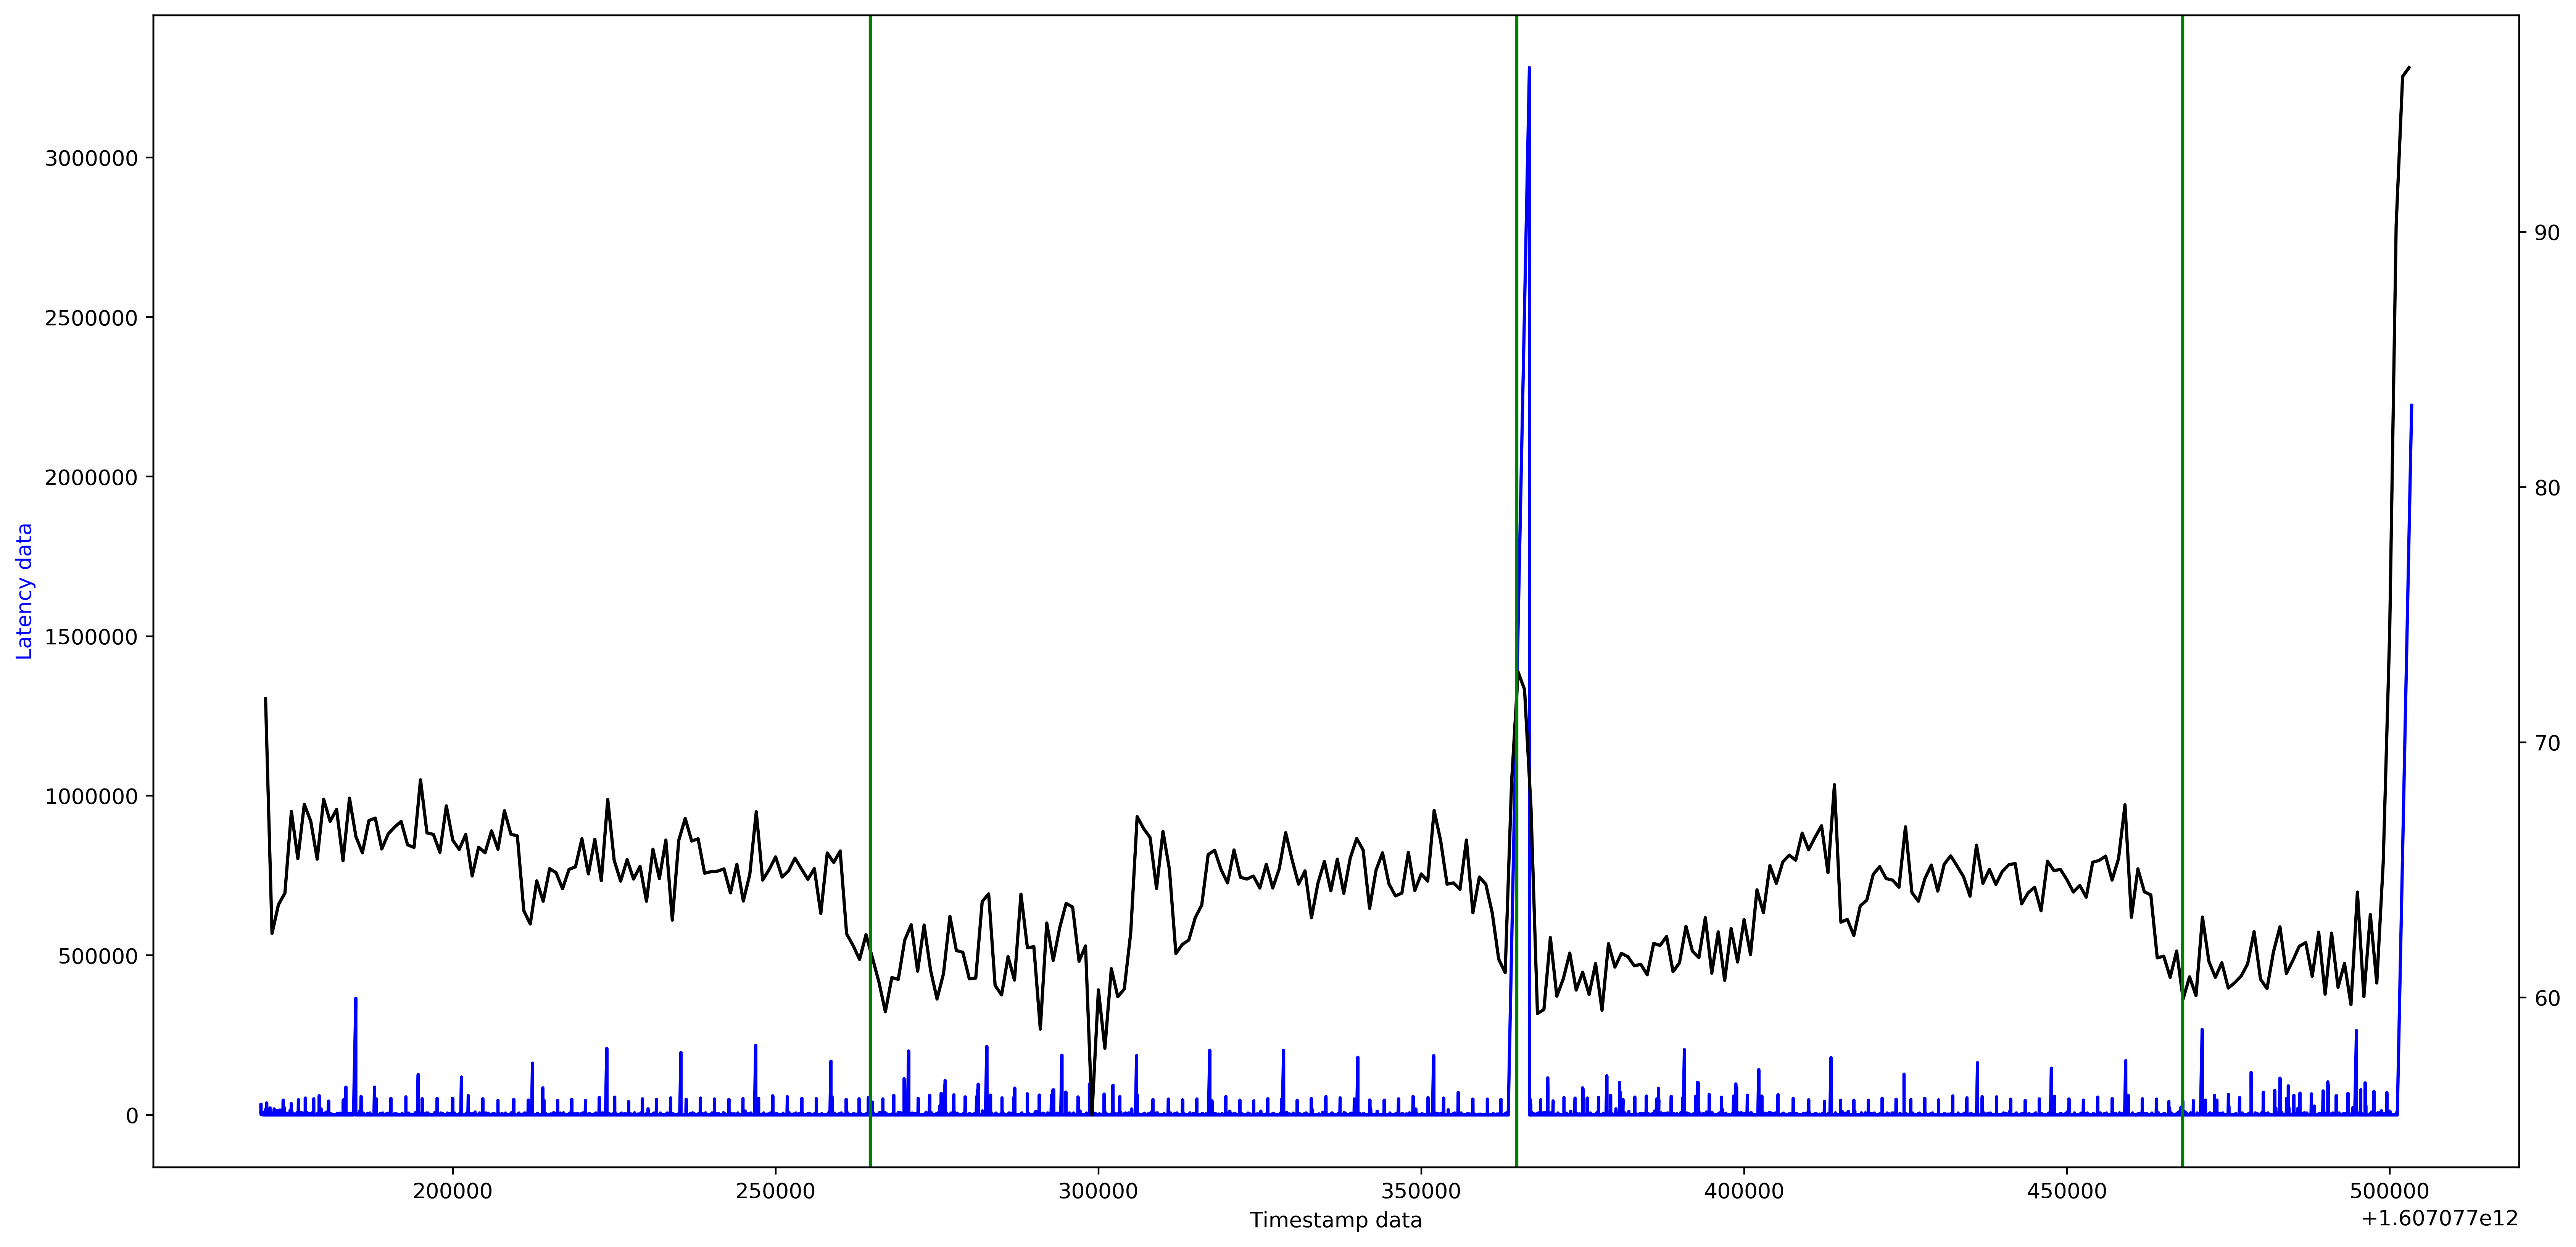

In [75]:
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=400)

ax2 = ax1.twinx()
ax1.plot(df.timestamp[initial_records:], df.latency[initial_records:], color='b')
ax2.plot(cpu_util.timestamp, cpu_util['%idle'],color = 'k')

# ax2.plot(gc_logs.timestamp, gc_logs.total_time, color='r')

for index, row in compactions.iterrows():
    ax2.axvline(x=row['start_utc'], color='g')
#     ax2.axvline(x=row['end_utc'], color='k')


ax1.set_xlabel('Timestamp data')
ax1.set_ylabel('Latency data', color='b')

plt.xlabel("Timestamp\n\nCassandra")
plt.show()

### Plotting Latency and Memory Usage

In [88]:
mem_util = pd.read_csv('./memutil.csv', skiprows = 1,header = None, names=['time', 'IST', 'kbmemfree', 'kbavail', 'kbmemused', '%memused',
       'kbbuffers', 'kbcached', 'kbcommit', '%commit', 'kbactive', 'kbinact',
       'kbdirty'])

In [89]:
def mem_to_utc(dt):
    local = pytz.timezone ('Asia/Kolkata')
    if(dt[0:2] == "03"): 
        dt = date_today + " 15:" + dt[3:] 
    else:
        dt = date_today + " 16:" + dt[3:]
        
    naive_datetime = datetime.datetime.strptime (dt, "%Y-%m-%d %H:%M:%S")
    local_datetime = local.localize(naive_datetime, is_dst=None)
    utc_dt = local_datetime.astimezone(pytz.utc)
    return utc_dt.timestamp()*1000

In [90]:
mem_util['timestamp'] = mem_util['time'].apply(mem_to_utc)

In [93]:
mem_util = mem_util.loc[(mem_util['timestamp'] >= start_time) & (mem_util['timestamp'] < end_time)]

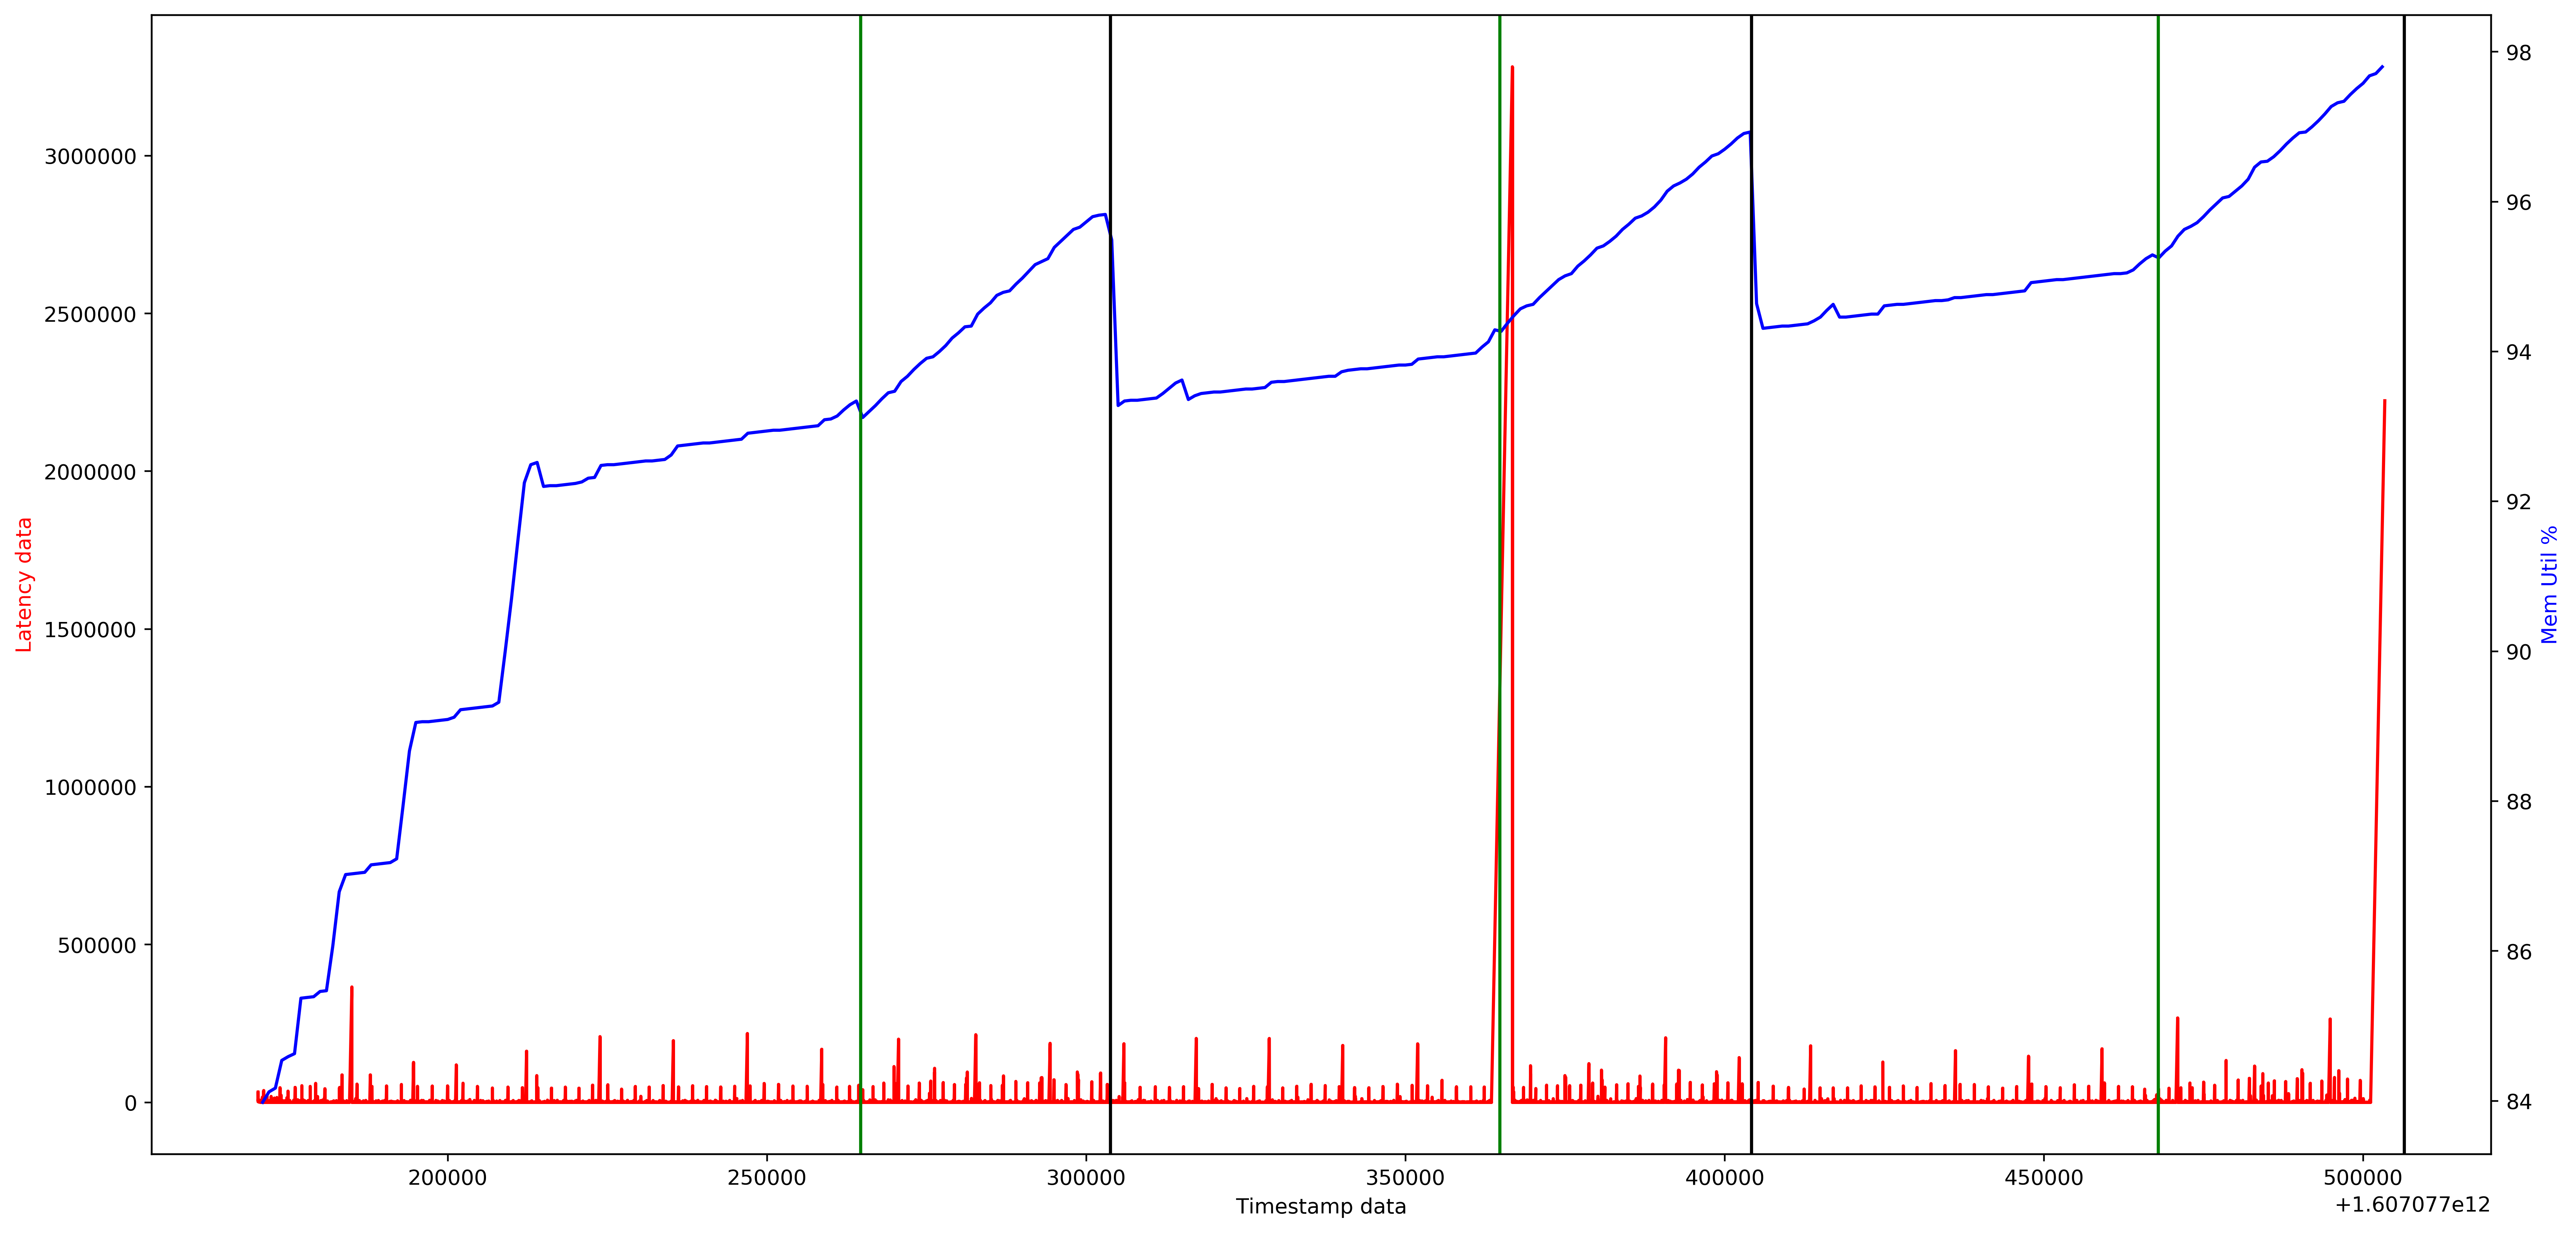

In [95]:
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=400)

ax2 = ax1.twinx()
ax2.plot(mem_util.timestamp, mem_util['%memused'],color='b' )
ax1.plot(df.timestamp[initial_records:], df.latency[initial_records:], color='r')

for index, row in compactions.iterrows():
    ax2.axvline(x=row['start_utc'], color='g')
    ax2.axvline(x=row['end_utc'], color='k')

ax1.set_xlabel('Timestamp data')
ax1.set_ylabel('Latency data', color='r')
ax2.set_ylabel('Mem Util %', color='b')

plt.xlabel("Timestamp\n\nCassandra")
plt.show()

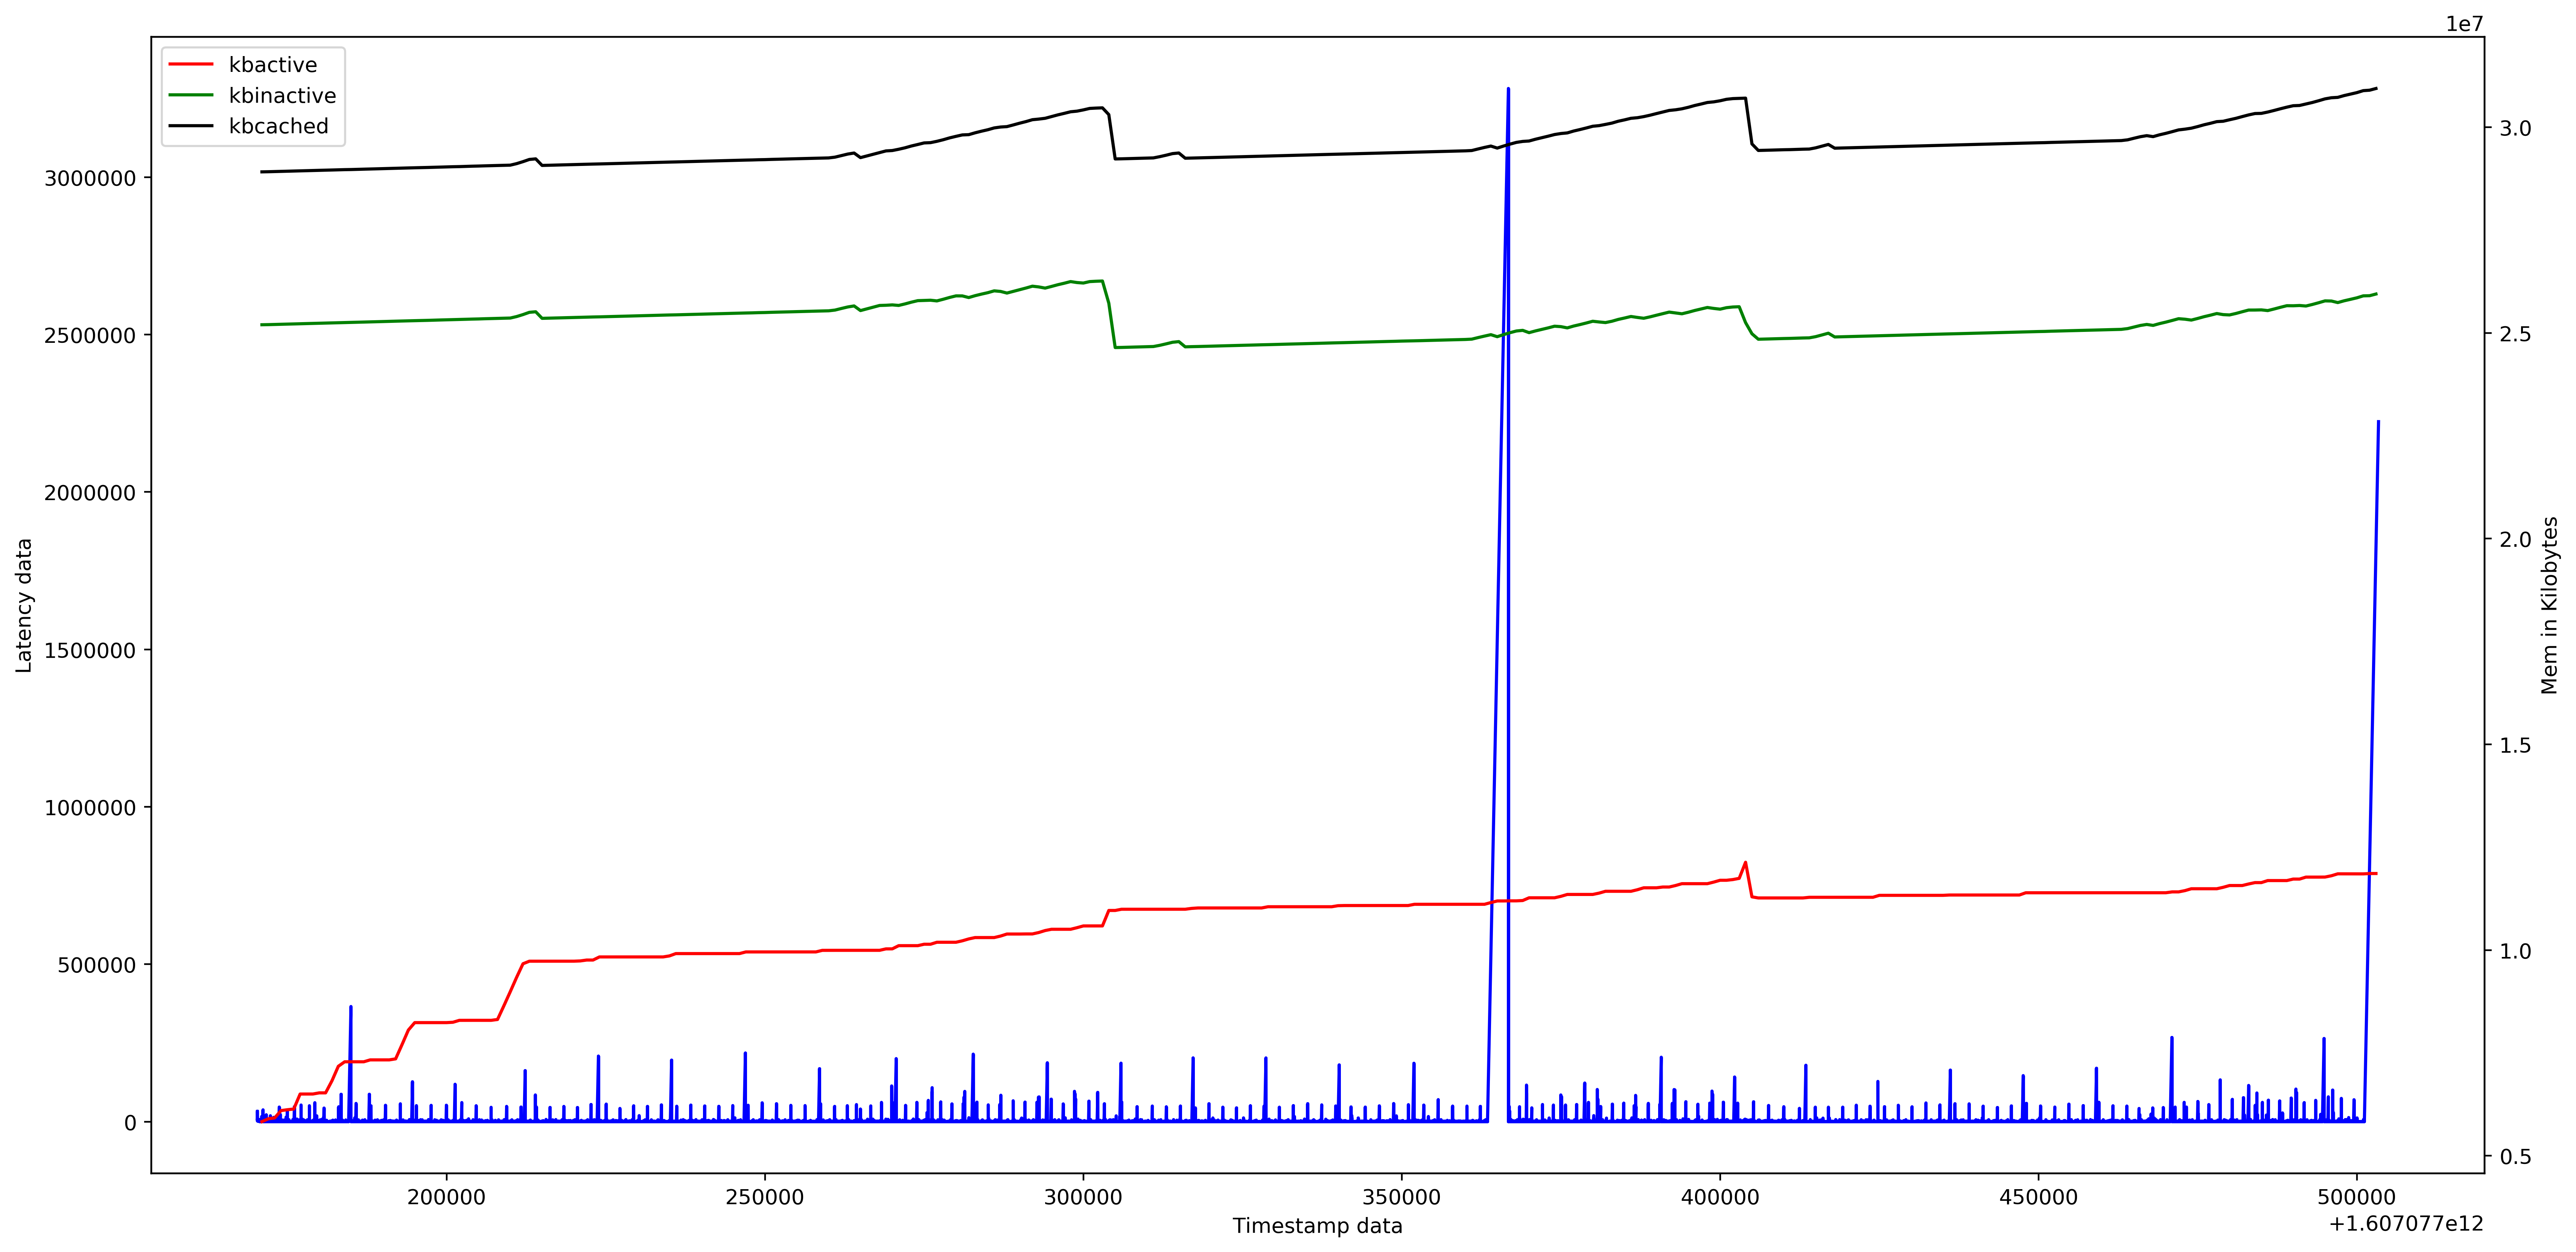

In [96]:
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=400)

ax2 = ax1.twinx()
ax1.plot(df.timestamp[initial_records:], df.latency[initial_records:], color='b')
ax2.plot(mem_util.timestamp, mem_util['kbactive'],color='r' )
ax2.plot(mem_util.timestamp, mem_util['kbinact'],color='g' )
ax2.plot(mem_util.timestamp, mem_util['kbcached'],color='k' )

ax1.set_xlabel('Timestamp data')
ax1.set_ylabel('Latency data')
ax2.set_ylabel('Mem in Kilobytes')

labels = ['kbactive', 'kbinactive', 'kbcached']
plt.legend(labels, loc="upper left")

plt.xlabel("Timestamp\n\nCassandra")
plt.show()

### Miscellaneous

In [47]:
x = df.nlargest(20, ['latency'])
x

,operation,timestamp,latency
5449394,READ,1.607077e+12,3281802
5449392,READ,1.607077e+12,3281684
12950656,UPDATE,1.607077e+12,3281460
12950657,UPDATE,1.607077e+12,3281459
12950653,UPDATE,1.607077e+12,3281450
12950651,UPDATE,1.607077e+12,3281259
12950649,UPDATE,1.607077e+12,3281224
12950650,UPDATE,1.607077e+12,3281215
5449384,READ,1.607077e+12,3280813
5449383,READ,1.607077e+12,3280774


In [48]:
insert_failed = list(df.index[df['operation'] == 'INSERT-FAILED'].tolist())
len(insert_failed)

0

In [49]:
update_failed = list(df.index[df['operation'] == 'UPDATE-FAILED'].tolist())
len(update_failed)

0